## Poisson equation
To demonstrate a product space solve, we'll consider

$$
\begin{align*}
    -\Delta u &= f \text{ in }\Omega\\
    u &= 0 \text{ on }\partial\Omega
\end{align*}
$$

where $\Omega$ is the unit square.
When $f(x,y) = 2x(y-1)(xy-2x+y+2)\exp(x-y)$,
the equation has analytic solution

$$u(x,y) = -x(1-x)y(1-y)\exp(x-y)$$

In [2]:
import numpy as np
from fenics import *
from product_fem import product_fem as pf

n = 22 # mesh resolution
mesh = UnitIntervalMesh(n-1)
V1 = FunctionSpace(mesh, 'CG', 1)
V = pf.ProductFunctionSpace(V1)
assert V._marginal_mesh == mesh

### Product space weak formulation
For the above Poisson equation the weak formulation is:
find $u$ such that $a(u,v) = L(v)$ for all $v$, where

$$
    a(u,v) = \int_\Omega\! \nabla u \cdot \nabla v\, d\mathbf{x}, \qquad L(v) = \int_\Omega\! fv \, d\mathbf{x}
$$

Since $\Omega = (0,1)\times(0,1)$ we can approximately solve the weak formulation using linear CG elements
defined only on the unit interval. 
That is, given a finite element basis $\{\phi_i\}$ on $(0,1)$ it follows that $\{\phi_i\phi_j\}$ is a finite element basis on the product space $\Omega$.
Thus we seek to solve $Au = b$ where 
$A_{ij,k\ell} = a(\phi_k\phi_\ell, \hat\phi_i\hat\phi_j)$ 
and $b_{ij} = L(\hat\phi_i\hat\phi_j)$. 
Let's write these down and apply Fubini's theorem to 
convert the product space integral to a product of integrals over $(0,1)$:

$$
    A_{ij,k\ell} = 
    \iint_\Omega\! \nabla \phi_j \cdot \nabla \hat\phi_i\, dxdy = 
    \int_0^1\! \phi_k'\hat\phi_i' \, dx 
    \int_0^1\! \phi_\ell\hat\phi_j \, dy + 
    \int_0^1\! \phi_k\hat\phi_i \, dx 
    \int_0^1\! \phi_\ell'\hat\phi_j'  \, dy
$$

In [ ]:
# assembly
u, v = TrialFunction(V1), TestFunction(V1)
B_form = u.dx(0) * v.dx(0) * dx
C_form = u * v * dx
A_forms = [B_form, C_form]

After a projection to the product basis we may assume
$f(x,y) = \sum_k X_k(x)Y_k(y)$, so that

$$
    b_{ij} = 
    \iint_\Omega\! f \hat\phi_i\hat\phi_j\, dxdy =
    \sum_k\int_0^1\! X_k \hat\phi_i \, dx 
    \int_0^1\! Y_k \hat\phi_j  \, dy
$$

In [ ]:
# force function sum_i X_iY_i
X = ['2 * x[0] * exp(x[0])', 
     '-4 * x[0] * x[0] * exp(x[0])',
     '2 * x[0] * x[0] * exp(x[0])', 
     '4 * x[0] * exp(x[0])']
X = [Expression(x, element=V1.ufl_element()) for x in X]

Y = ['x[0] * (x[0] - 1) * exp(-x[0])', 
     '(x[0] - 1) * exp(-x[0])',
     'x[0] * (x[0] - 1) * exp(-x[0])', 
     '(x[0] - 1) * exp(-x[0])']
Y = [Expression(y, element=V1.ufl_element()) for y in Y]

c_forms = [fx * v * dx for fx in X]
d_forms = [fy * v * dx for fy in Y]
b_forms = [c_forms, d_forms]

### Assembly and boundary conditions

In [3]:
bc = pf.ProductDirichletBC(V, 0)

A, b = pf.assemble_product_system(A_forms, b_forms, bc)
u_h = np.linalg.solve(A, b)

### $L^2$ error mesh convergence
We should expect the $L^2$ norm to decay with
increasing mesh resolution $h$.
It can be shown that the FEM solution $u_h$
with degree $p$ CG elements will converge to
the analytic solution $u$ according to

$$
\| u - u_h \|_2 \approx Ch^{p+1}
$$

for some constant $C$. Here we take $h$ to be the 
maximum edge length of the mesh.
For example, a mesh on $[0,1]$ with $n$ evenly spaced
nodes will have $h=\frac{1}{n-1}$.
To sanity check this we'll compute $\|u - u_h\|_2$ 
for increasing values of $n$, fit a linear model
to $\log(\|u - u_h\|_2) \sim \log(h)$, 
and confirm the slope is near $p+1$.

In [8]:
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def mesh_res_error(n):
    mesh = UnitIntervalMesh(n-1)
    h = mesh.hmax()
    V = FunctionSpace(mesh, 'CG', 1)
    W = prod.ProductFunctionSpace(V)

    bc = prod.ProductDirichletBC(W, 0)

    # force function sum_i X_iY_i
    X = ['2 * x[0] * exp(x[0])', 
         '-4 * x[0] * x[0] * exp(x[0])',
         '2 * x[0] * x[0] * exp(x[0])', 
         '4 * x[0] * exp(x[0])']
    X = [Expression(x, element=V.ufl_element()) for x in X]

    Y = ['x[0] * (x[0] - 1) * exp(-x[0])', 
         '(x[0] - 1) * exp(-x[0])',
         'x[0] * (x[0] - 1) * exp(-x[0])', 
         '(x[0] - 1) * exp(-x[0])']
    Y = [Expression(y, element=V.ufl_element()) for y in Y]

    # assembly
    u, v = TrialFunction(V), TestFunction(V)
    B_form = u.dx(0) * v.dx(0) * dx
    C_form = u * v * dx
    A_forms = [B_form, C_form]

    c_forms = [fx * v * dx for fx in X]
    d_forms = [fy * v * dx for fy in Y]
    b_forms = [c_forms, d_forms]

    A, b = prod.assemble_product_system(A_forms, b_forms, bc)
    u_h = np.linalg.solve(A, b)

    # can compute integrals using mass matrix M_ij = int phi_i dx * int phi_j dy
    # then int f(x,y) dxdy = sum_ij int f_ij phi_i(x) phi_j(y) dxdy
    #                      = sum_ij f_ij M_ij
    mass = assemble(v * dx)[:]
    mass = np.kron(mass, mass)

    # convergence checking
    # errornorm(u, u_h) = int (u-u_anal)^2 dx
    dof_to_coords = W.dofmap._dofs_to_coords
    u = np.zeros_like(u_h)
    analytic_u = lambda x,y: x * (x - 1) * y * (1 - y) * np.exp(x - y)
    for dof, xy in dof_to_coords.items():
        u[dof] = analytic_u(*xy)
    l2_error = np.dot((u - u_h)**2, mass)

    return h, np.sqrt(l2_error)

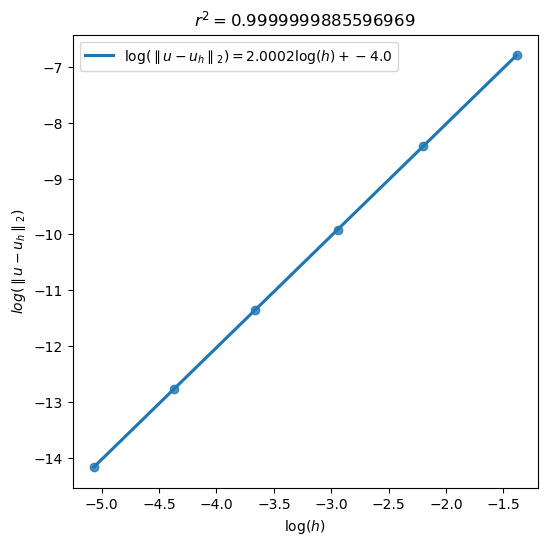

In [10]:
# organize data frame
ns = [5, 10, 20, 40, 80, 160]
h_errors = np.array([mesh_res_error(n) for n in ns])
hs, l2_err = h_errors[:,0], h_errors[:,1]
data = {'n': ns, 'h': hs, 'log_h': np.log(hs), 'l2_err': l2_err, 'log_l2_err': np.log(l2_err)}
data = pd.DataFrame(data)

# perform regression and plot
slope, intercept, r, p, se = stats.linregress(data['log_h'], data['log_l2_err'])
line_kws={'label':fr'$\log(\parallel u - u_h\parallel_2) = {np.round(slope, 4)} \log(h) + {np.round(intercept, 1)}$'}
ax = sns.regplot(x='log_h', y='log_l2_err', data=data, 
                 ci=None, order=1, line_kws=line_kws)
# aesthetics
ax.figure.set_dpi(100)
ax.figure.set_figheight(6)
ax.figure.set_figwidth(6)
ax.set_xlabel(r'$\log(h)$')
ax.set_ylabel(r"$ log(\parallel u - u_h\parallel_2)$")
ax.set_title(fr'$r^2 = {r**2}$')
ax.legend()
plt.show()

Evidently $\|u - u_h\|_2 \approx \mathcal{O}(h^2)$, as claimed.